# Comparison by quadrant
Remember that each SAR image is centered on the TC center and that the SAR image has been rotated so that the TC translates along the y-axis in the upper direction (= toward the "North").

1) We first compare the profiles fitting in each quadrant, using 2 methods. In a first method (PARAMS['profile_fit_without_quadrant'] = False), the profiles are fitted in each quadrant, and compared to the observations in each quadrant. In a second method (PARAMS['profile_fit_without_quadrant'] = True) the profiles are fitted on the azimuthally averaged wind speed, but still compared to the observations in each quadrant. Note that in this second method, the Rmax used to define the r*-axis is the Rmax relative to the observation in each quadrant (and not the Rmax of the aziumthally-averaged wind speed).

2) We then plot the scatter for Rmax and Vmax, by quadrant, for each profile, using the same 2 methods as for 1).



In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit

import glob

import functions as f

In [2]:
### PATHS
# dir_path = '/home/arthur/data/cyclobs/rotated_files/'
dir_path = '/home/arthur/data/cyclobs/rotated_files/clean_dataset/'
all_data = glob.glob(dir_path + "*.nc")
print("Total number of files:", len(all_data))
# Savepath to be modified directly in the function

### PARAMS
PARAMS = {
    'r_window_len':                 501,  # Scale for radius (km)
    'rmax_window':                  300,  # Window in whick we look for Rmax (e.g [0, 200km])
    'chavas_vfit':                  17,
    'rank_hol_will_vmin':           True, # Uses Vmin as a free parameter if True. If False, Vmin = 0
    'chavas_vmin':                  False, # Translates the profile from Vmin if True
    
    'r_Rmax_axis':                  True, # If True, uses r* = r/Rmax as x-axis
    'r_Rmax_scale':                 16.,
    'r_Rmax_num_pts':               321,
    
    'profile_fit_without_quadrant': True, # If True, the profile is first fitted without quadrant but compared with obs of each quadrant
    
    'use_curve_fit':                True,
    'tangential_wind_speed':        True, # If False, total wind speed is used
    'print_values':                 False, 
    
    'save_dir':                     "/home/arthur/results/windProfiles/test9/",
    'save_comparison':              False,
    'save_scatter':                 False
    }

Total number of files: 322


In [3]:
# INITIALIZE DATA STRUCTURE
INI = {           # Initial values
    'Rankine':    [], # x, alpha, Vmin, Rmax
    'Holland':    [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'Willoughby': [], # n, X1, Vmin, Rmax, Vmax
    'Chavas':     []  # Vmax, Vmin, Rfit, Vfit, fcor, Cdvary, Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye
    } 
FIT = {           # Fit values
    'Rankine':    [], # x, alpha, Vmin, Rmax
    'Holland':    [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'Willoughby': [], # n, X1, Vmin, Rmax, Vmax
    'Chavas':     []  # rr, VV, rmax, r0, rmerge, Vmerge
    }
# GAP WITH OBSERVATIONS
NB_CAT    = [None] * 6
DIFF      = [None] * 6
RMAX_OBS  = [None] * 6
RMAX_FIT  = [None] * 6
VMAX_OBS  = [None] * 6
VMAX_FIT  = [None] * 6
FIT_PARAMS= [None] * 6
r_axis_length = PARAMS['r_window_len']
if PARAMS['r_Rmax_axis']:
    r_axis_length = PARAMS['r_Rmax_num_pts']    
# Comparison by quadrants
SPD = {
    'FR': [], # Front-right quadrant
    'FL': [], # Front-left quadrant
    'RL': [], # Rear-right quadrant
    'RR': []  # Rear-left quadrant
}
DIFF_QUAD = {
    'FR': [None] * 6,
    'FL': [None] * 6,
    'RL': [None] * 6,
    'RR': [None] * 6
}
NB_CAT_QUAD = {
    'FR': [None] * 6,
    'FL': [None] * 6,
    'RL': [None] * 6,
    'RR': [None] * 6
}
RMAX_OBS_QUAD = {
    'FR': [None] * 6,
    'FL': [None] * 6,
    'RL': [None] * 6,
    'RR': [None] * 6
}
RMAX_FIT_QUAD = {
    'FR': [None] * 6,
    'FL': [None] * 6,
    'RL': [None] * 6,
    'RR': [None] * 6
}
VMAX_OBS_QUAD = {
    'FR': [None] * 6,
    'FL': [None] * 6,
    'RL': [None] * 6,
    'RR': [None] * 6
}
VMAX_FIT_QUAD = {
    'FR': [None] * 6,
    'FL': [None] * 6,
    'RL': [None] * 6,
    'RR': [None] * 6
}
for quadrant in DIFF_QUAD.keys():
    for i in range(6):
        DIFF_QUAD[quadrant][i]   = {
        'Rankine':    [0.] * r_axis_length,
        'Holland':    [0.] * r_axis_length,
        'Willoughby': [0.] * r_axis_length,
        'Chavas':     [0.] * r_axis_length 
        }
        NB_CAT_QUAD[quadrant][i] = {
        'Rank-Hol-Will': [0.] * r_axis_length,
        'Chavas':        [0.] * r_axis_length 
        }
        RMAX_OBS_QUAD[quadrant][i] = []
        RMAX_FIT_QUAD[quadrant][i] = {
        'Rankine':    [],
        'Holland':    [],
        'Willoughby': [],
        'Chavas':     [] 
        }
        VMAX_OBS_QUAD[quadrant][i] = []
        VMAX_FIT_QUAD[quadrant][i] = {
        'Rankine':    [],
        'Holland':    [],
        'Willoughby': [],
        'Chavas':     [] 
        }

1 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1b-ew-owi-cm-20180902t143708-20180902t143912-000003-01720F_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:662: RuntimeWarning: Mean of empty slice
  SPD[quadrant] = np.nanmean(spd[i:i + 90, :], axis=0)
/home/arthur/scripts/windProfiles/symmetric/functions.py:274: RuntimeWarning: divide by zero encountered in true_divide
  V_ER11 = (1. / rr_ER11) * (Vmax * rmax + .5 * fcor * rmax ** 2) * ((2 * (rr_ER11 / rmax) ** 2) / (2 - CkCd + CkCd * (rr_ER11 / rmax) ** 2)) ** (1 / (2 - CkCd)) - .5 * fcor * rr_ER11
/home/arthur/scripts/windProfiles/symmetric/functions.py:274: RuntimeWarning: invalid value encountered in multiply
  V_ER11 = (1. / rr_ER11) * (Vmax * rmax + .5 * fcor * rmax ** 2) * ((2 * (rr_ER11 / rmax) ** 2) / (2 - CkCd + CkCd * (rr_ER11 / rmax) ** 2)) ** (1 / (2 - CkCd)) - .5 * fcor * rr_ER11
/home/arthur/scripts/windProfiles/symmetric/functions.py:188: RuntimeWarning: invalid value encountered in true_divide
  VV = (Mm / rmax) * (MMfracMm / rrfracrm) - .5 * fcor * rmax * rrfracrm #[ms-1]


2 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/rs2--owi-cm-20150601t015945-20150601t020101-00003-BDBF8_ll_gd_rotated.nc
3 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1a-ew-owi-cm-20160827t092124-20160827t092414-000003-014249_ll_gd_rotated.nc
4 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1a-ew-owi-cm-20170207t015253-20170207t015558-000003-018D33_ll_gd_rotated.nc
5 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/rs2--owi-cm-20150509t232412-20150509t232525-00003-E0BD7_ll_gd_rotated.nc
6 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1a-ew-owi-cm-20181002t211106-20181002t211310-000003-029DF5_ll_gd_rotated.nc
7 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1a-iw-owi-cm-20170504t071401-20170504t071505-000003-01B35C_ll_gd_rotated.nc
8 =>     /home/arthur/data/cyclobs/rotated_files/clean_dataset/s1b-ew-owi-cm-20191106t194803-20191106t195007-000003-02377F_ll_gd_rotated.nc
9 =>     /home/arthur/data/c

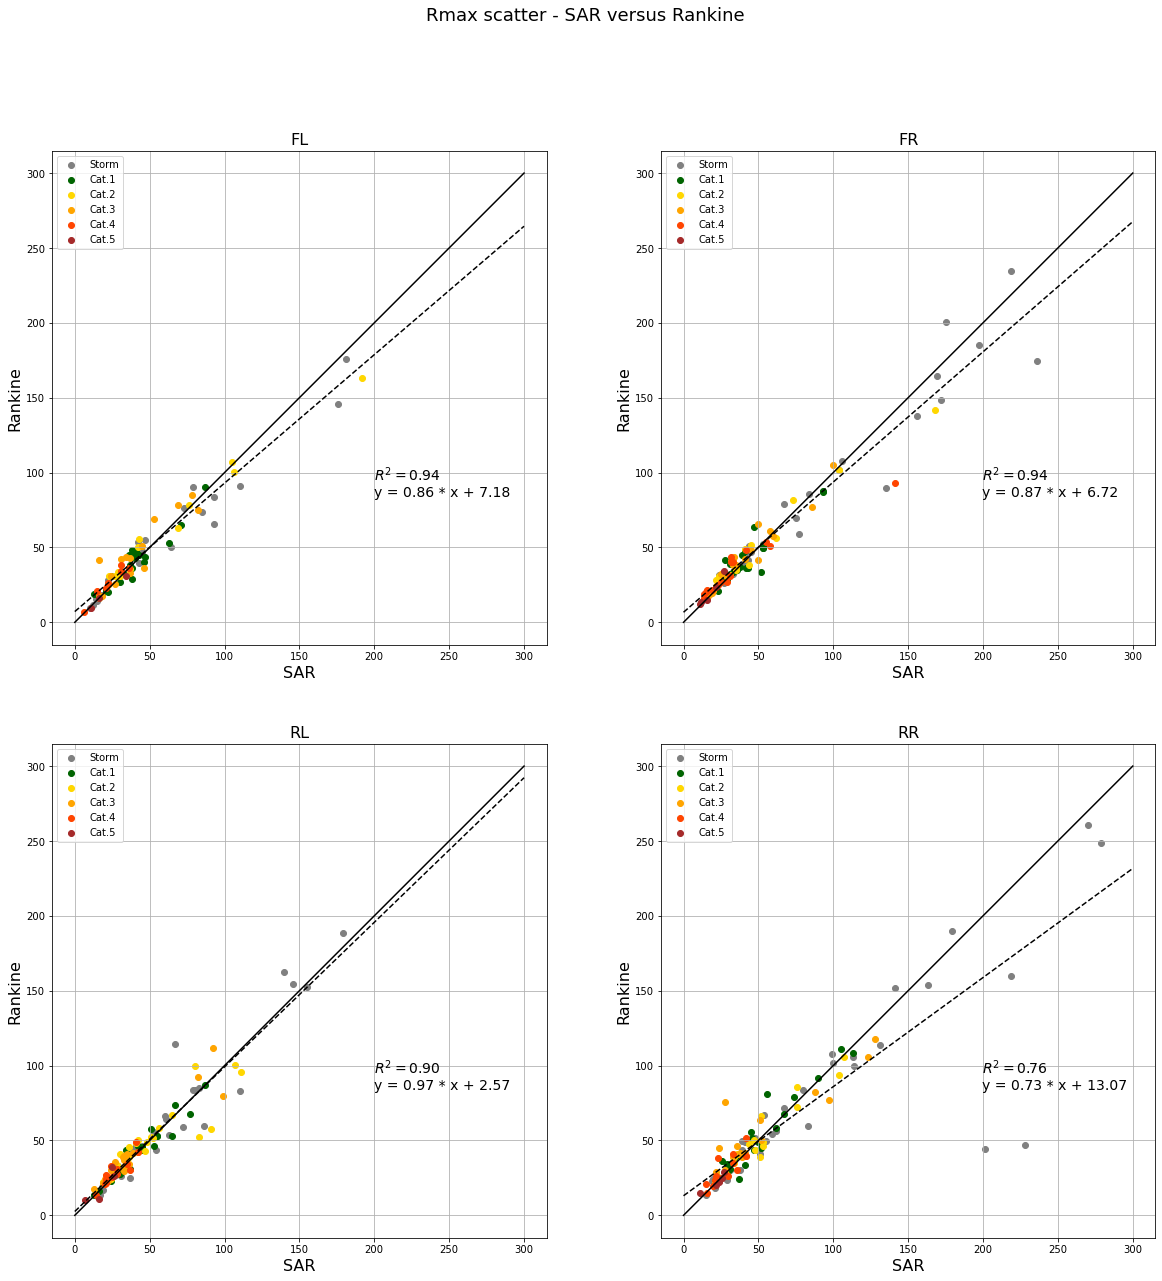

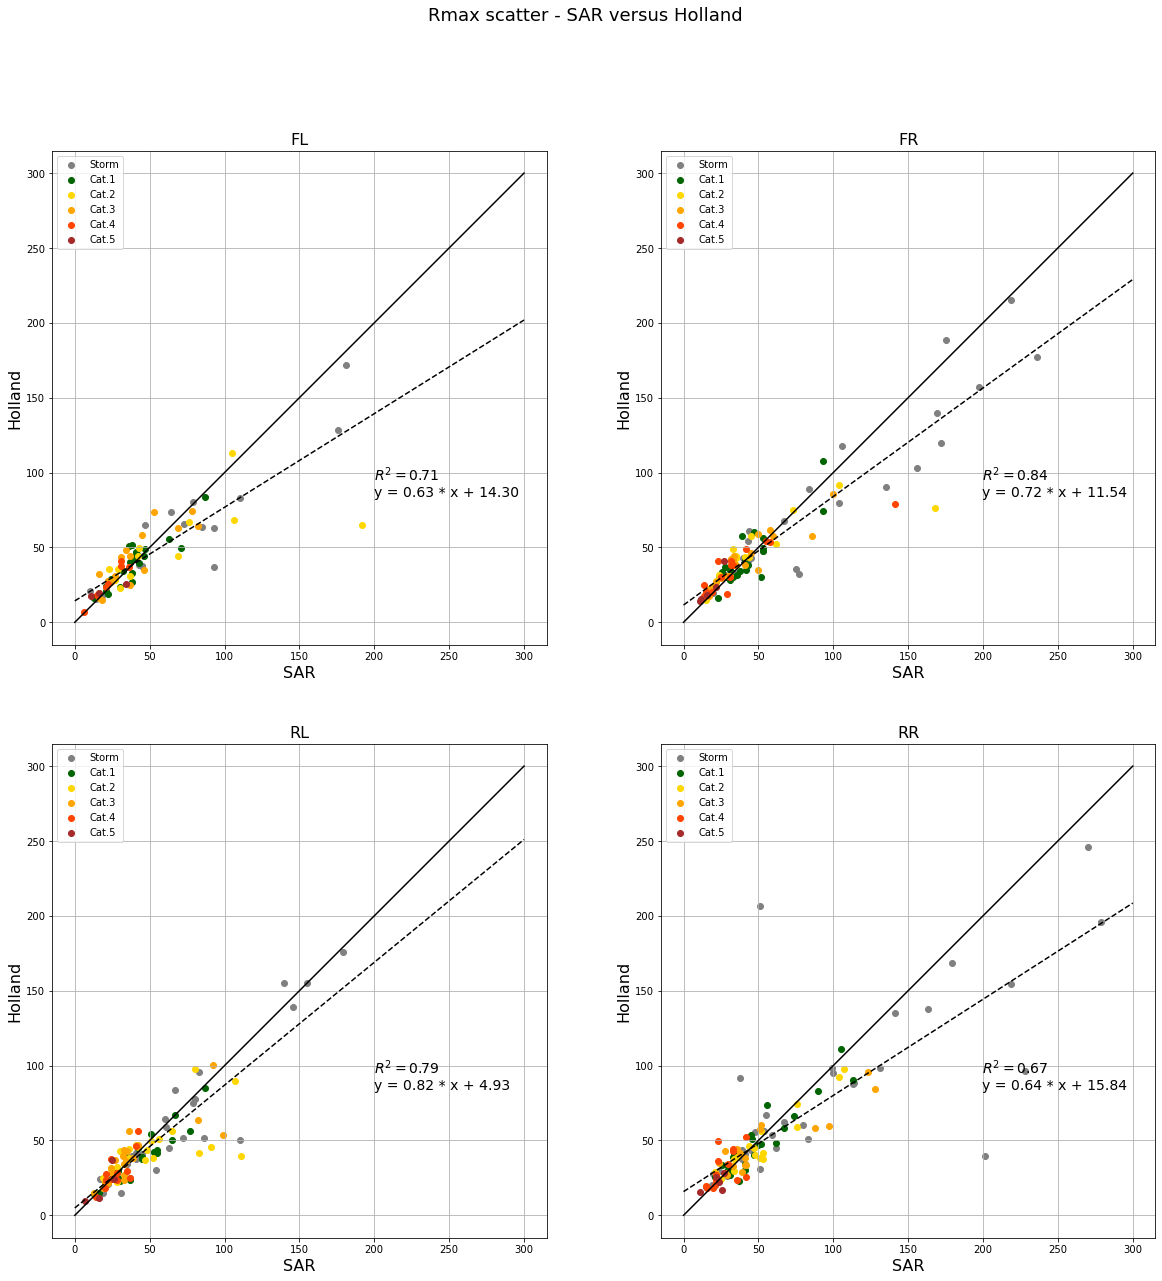

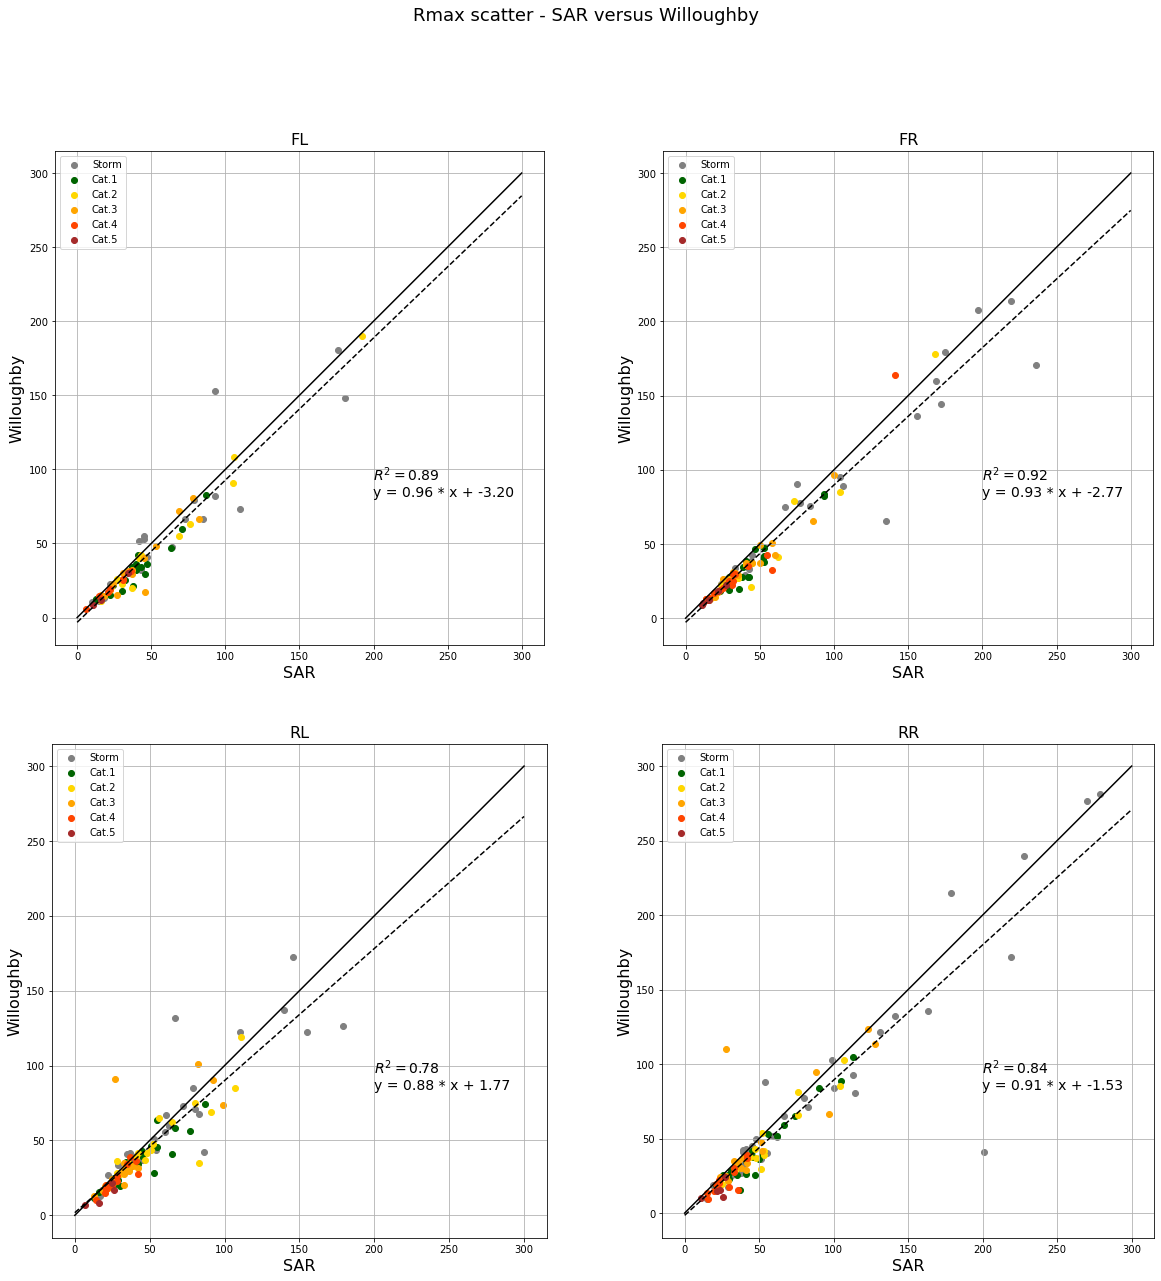

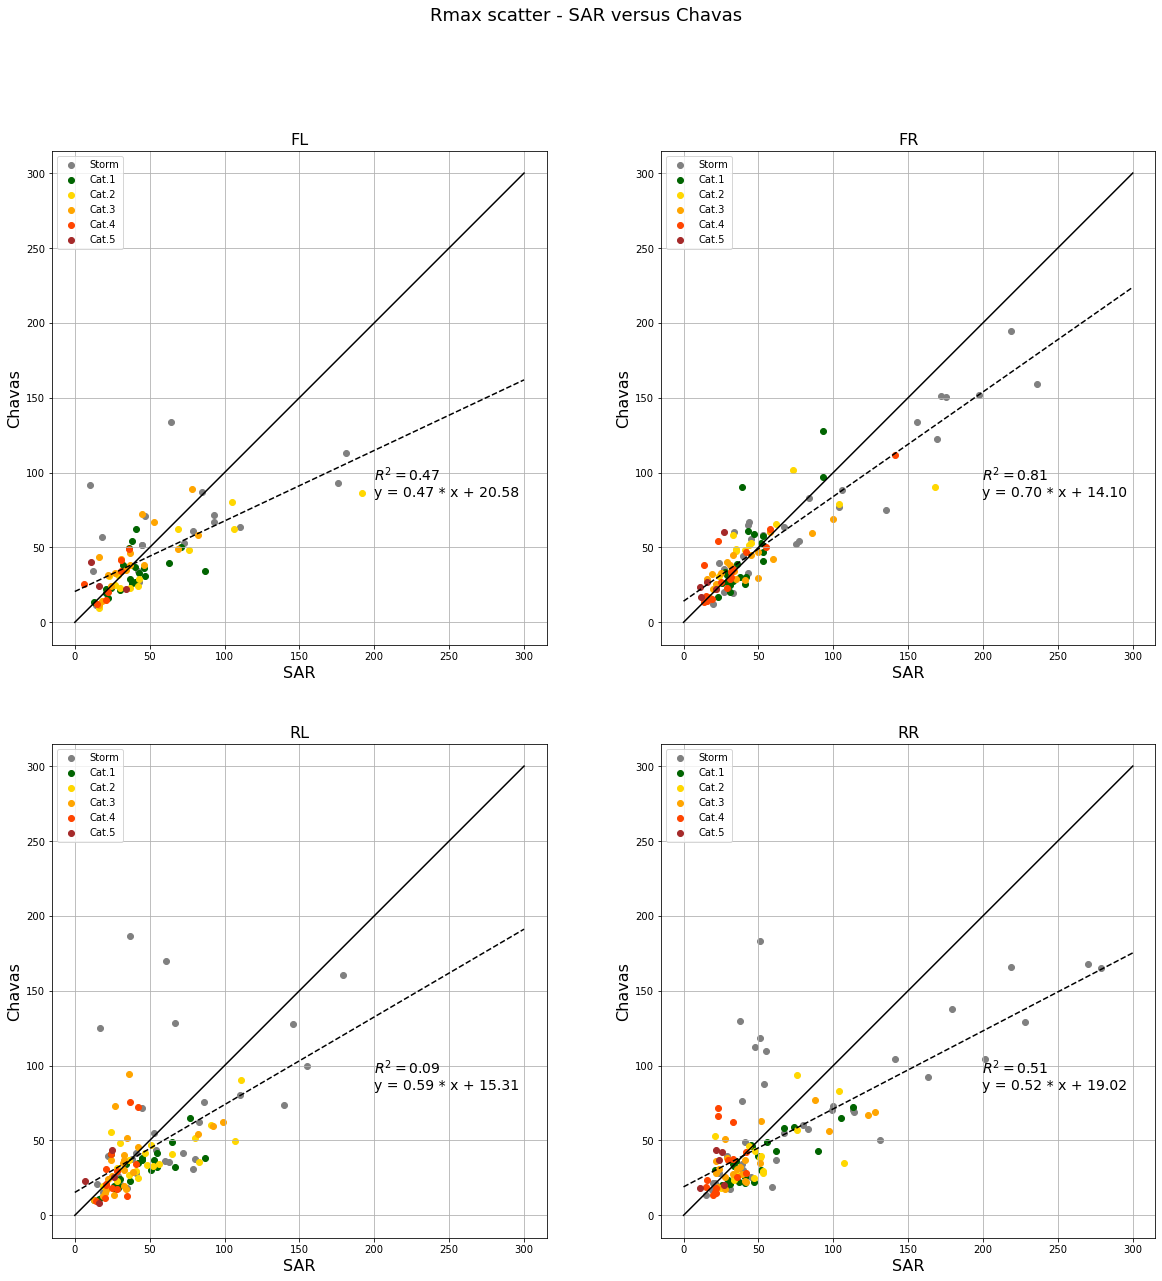

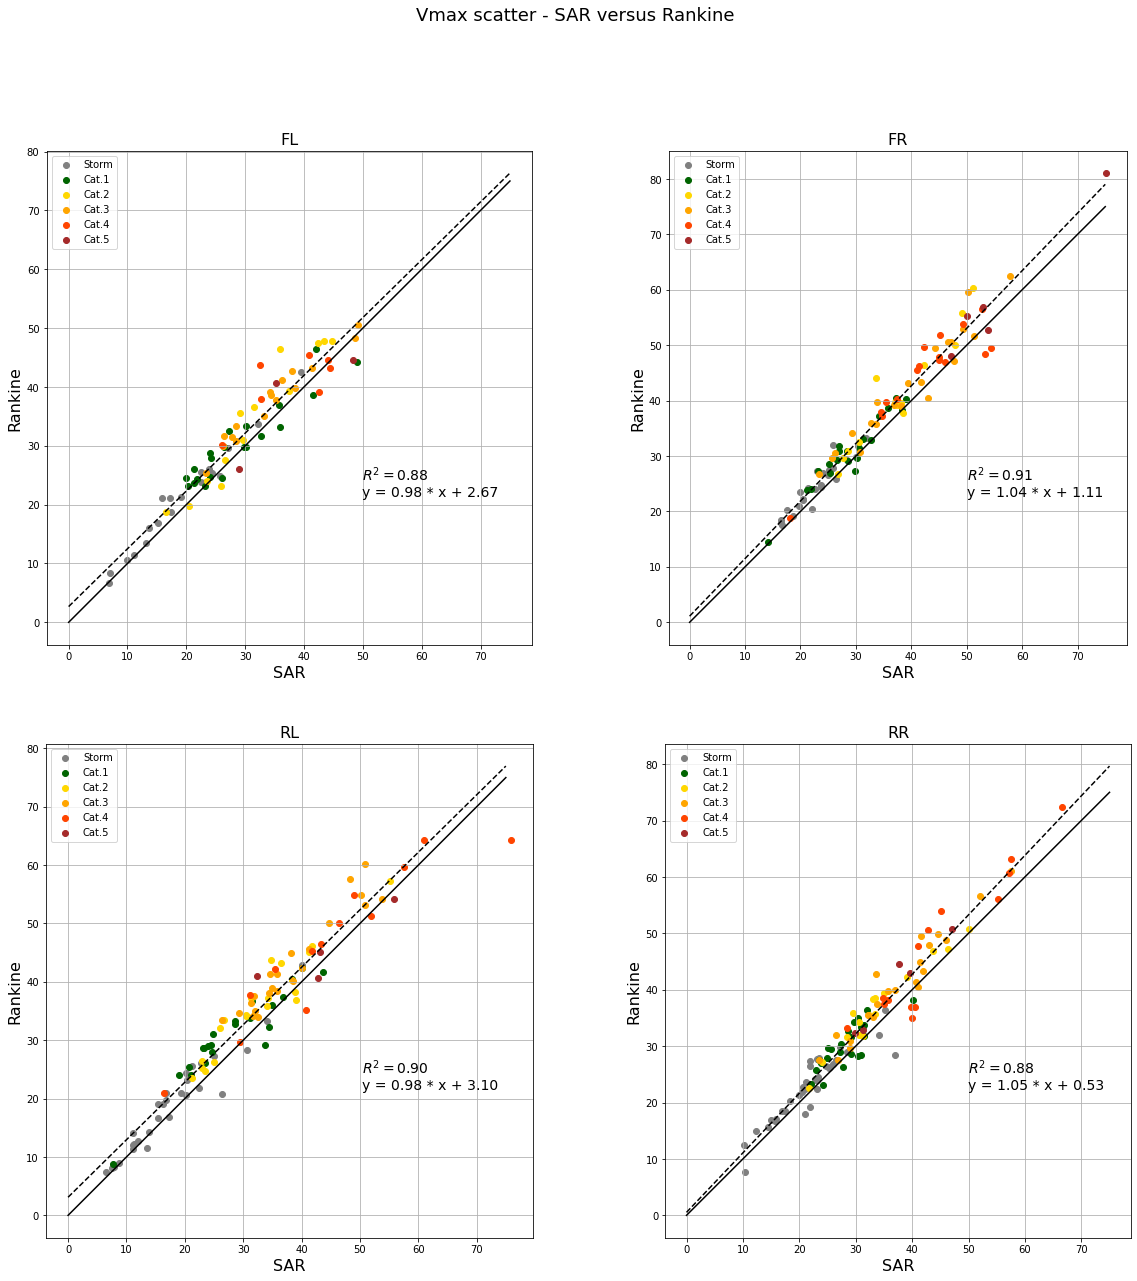

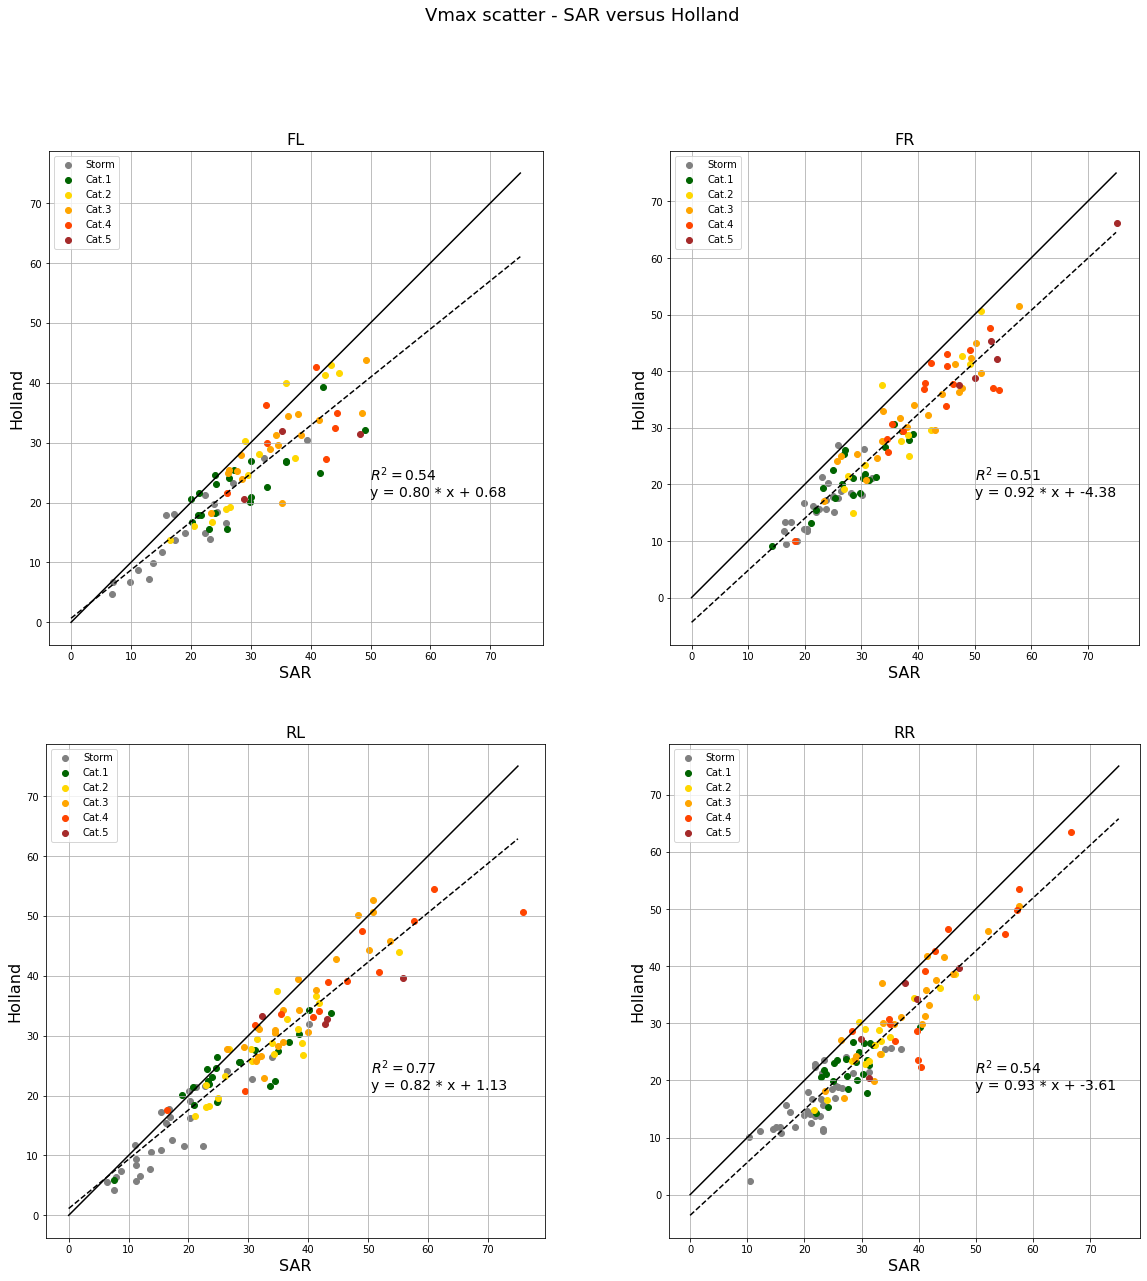

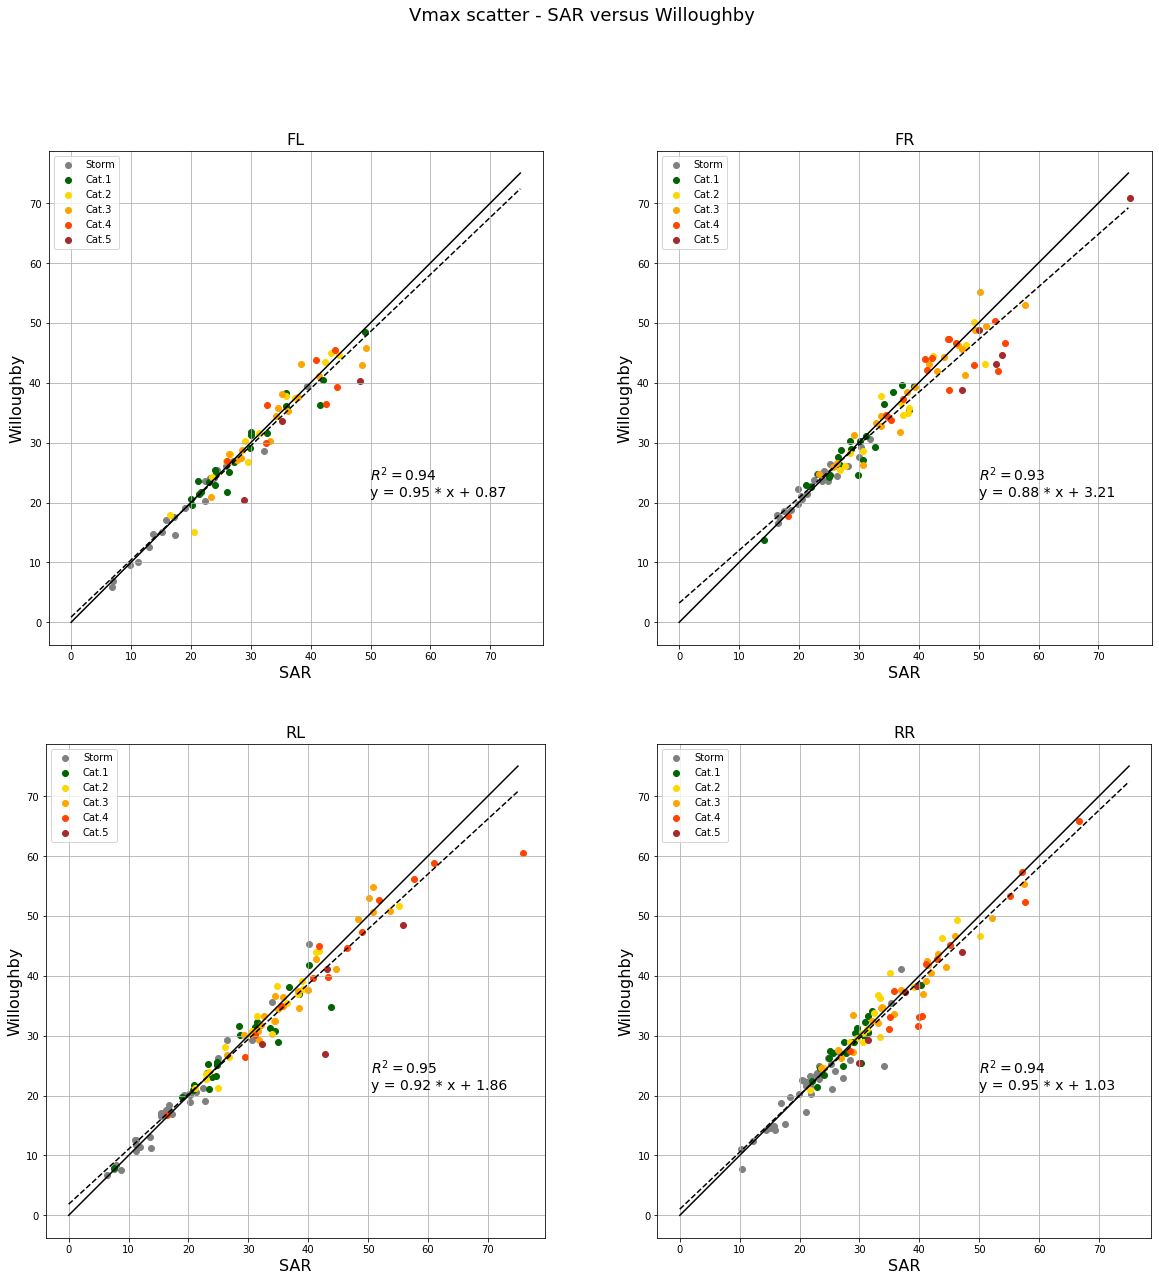

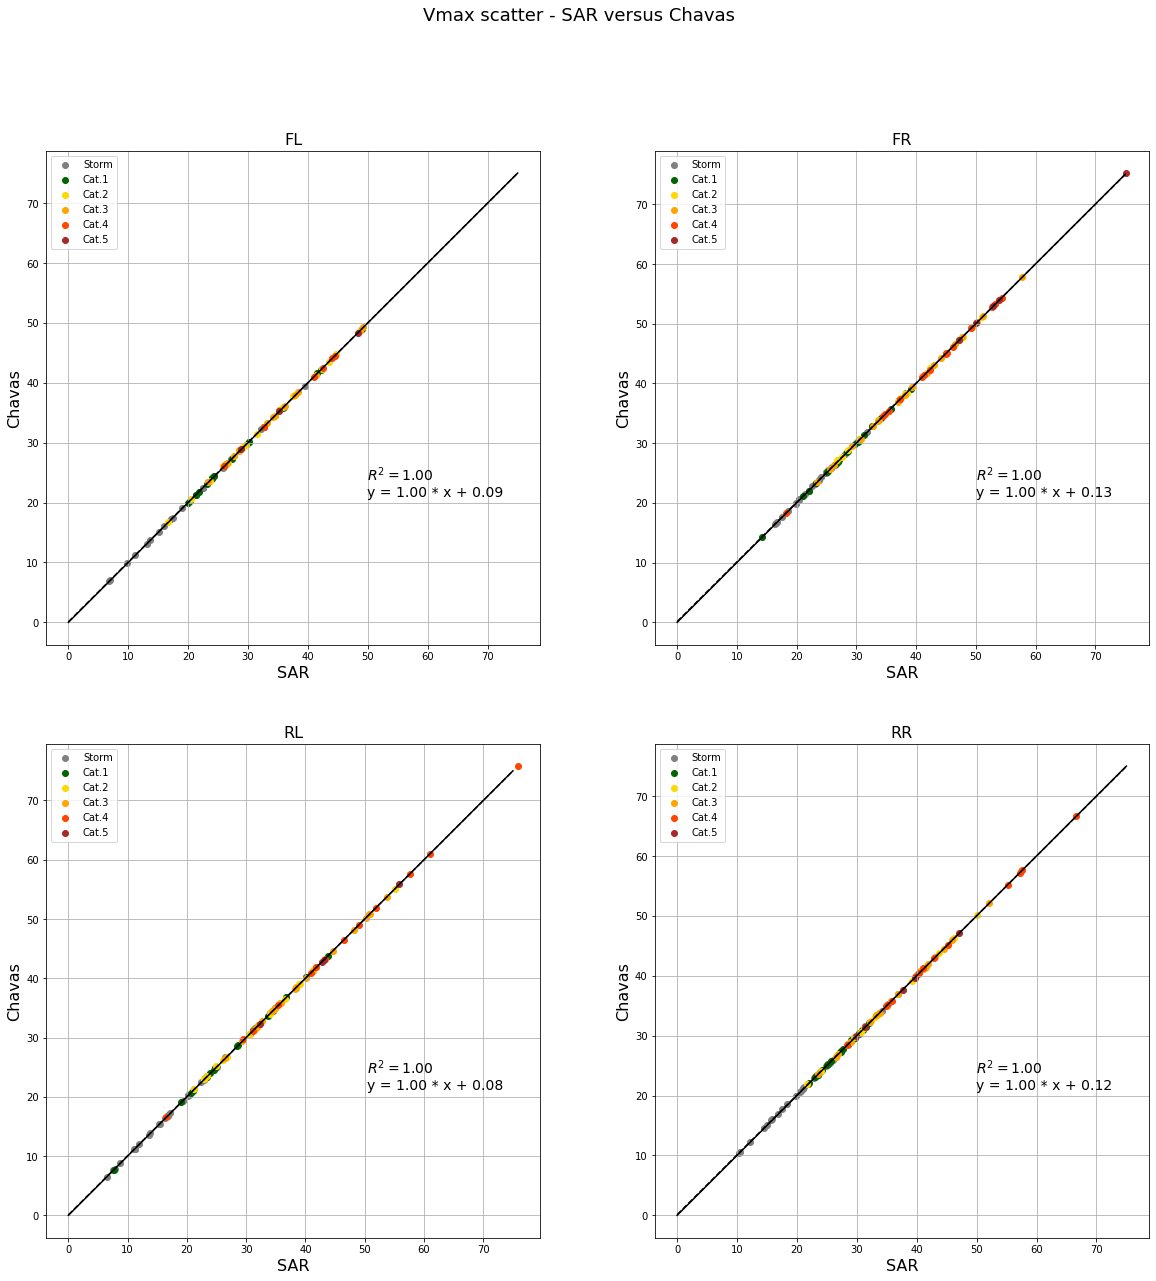

In [4]:
### ========================= BY QUADRANT ========================= 
# FIT AND PRINT ALL THE PROFILES ON ALL THE DATA BY QUADRANT
i   = 0
for file in all_data:
    i += 1
    print(i, "=>    ", file)
    # Open file and compute mean wind speed by quadrant
    ds  = xr.open_dataset(file)
    SPD = f.compute_mean_tangential_wind_spd_quadrants(ds, SPD, PARAMS)    
    
    if PARAMS['profile_fit_without_quadrant']: # If True, compute profiles on azimuthally-averaged wind speed obs
        spdm_without_quadrant = f.compute_mean_tangential_wind_spd(ds, r_window_len=PARAMS['r_window_len']) # TANGENTIAL WIND SPEED
        r, spdm, _            = f.initialize_radius(spdm_without_quadrant)
        INI['Rankine']        = f.initialize_rankine(spdm, x=0.5, alpha=1.,                                PARAMS=PARAMS)
        INI['Holland']        = f.initialize_holland(spdm, Lat=np.float64(ds['lat_ref']), pn=1005, pc=950, PARAMS=PARAMS)
        INI['Willoughby']     = f.initialize_willoughby(spdm, n=1.,                                        PARAMS=PARAMS)
        INI['Chavas']         = f.initialize_chavas(spdm, Lat=np.float64(ds['lat_ref']),                   PARAMS=PARAMS)
        FIT['Rankine']        = f.fit_rankine(r, spdm, *INI['Rankine'],                 PARAMS=PARAMS)
        FIT['Holland']        = f.fit_holland(r, spdm, *INI['Holland'],                 PARAMS=PARAMS)
        FIT['Willoughby']     = f.fit_willoughby_no_smooth(r, spdm, *INI['Willoughby'], PARAMS=PARAMS)
        FIT['Chavas']         = f.fit_chavas(*INI['Chavas'],                            PARAMS=PARAMS)
        Rmax, Vmax            = INI['Holland'][4], INI['Holland'][5]
        
    # Initialize and fit profile for each quadrant
    for quadrant in SPD.keys():
        if np.isnan(np.min(SPD[quadrant])):
            spdm = [0.]
        else: 
            r, spdm, first_valid_index = f.initialize_radius(SPD[quadrant])
        
        # print(len(spdm))
        if len(spdm) > 100 and PARAMS['profile_fit_without_quadrant'] == False: # In this case, fit one profile per quadrant
            INI['Rankine']    = f.initialize_rankine(spdm, x=0.5, alpha=1.,                                PARAMS=PARAMS)
            INI['Holland']    = f.initialize_holland(spdm, Lat=np.float64(ds['lat_ref']), pn=1005, pc=950, PARAMS=PARAMS)
            INI['Willoughby'] = f.initialize_willoughby(spdm, n=1.,                                        PARAMS=PARAMS)
            INI['Chavas']     = f.initialize_chavas(spdm, Lat=np.float64(ds['lat_ref']),                   PARAMS=PARAMS)

            FIT['Rankine']    = f.fit_rankine(r, spdm, *INI['Rankine'],                 PARAMS=PARAMS)
            FIT['Holland']    = f.fit_holland(r, spdm, *INI['Holland'],                 PARAMS=PARAMS)
            FIT['Willoughby'] = f.fit_willoughby_no_smooth(r, spdm, *INI['Willoughby'], PARAMS=PARAMS)
            FIT['Chavas']     = f.fit_chavas(*INI['Chavas'],                            PARAMS=PARAMS)

            Rmax, Vmax = INI['Holland'][4], INI['Holland'][5]
        
        if PARAMS['profile_fit_without_quadrant']: # We still use the Rmax of each quadrant to define r*
            _, _, _, _, Rmax, Vmax = f.initialize_holland(spdm, Lat=np.float64(ds['lat_ref']), pn=1005, pc=950, PARAMS=PARAMS)
        
        if len(spdm) > 100:
            ### Comparison by category, function of r_star
            DIFF_QUAD[quadrant], NB_CAT_QUAD[quadrant] = f.calculate_diff_by_cat(ds['current_category'], Rmax, r, spdm, INI, FIT, DIFF_QUAD[quadrant], NB_CAT_QUAD[quadrant], PARAMS)
        
            ### Scatter-plots
            RMAX_OBS_QUAD[quadrant], RMAX_FIT_QUAD[quadrant], VMAX_OBS_QUAD[quadrant], VMAX_FIT_QUAD[quadrant] = f.add_to_scatter_list(\
                ds['current_category'], r, Rmax, Vmax, FIT,\
                RMAX_OBS_QUAD[quadrant], RMAX_FIT_QUAD[quadrant], VMAX_OBS_QUAD[quadrant], VMAX_FIT_QUAD[quadrant], PARAMS
                )
        
            ### Compute mean fitted parameters by category
            # FIT_PARAMS   = f.calculate_fitted_params_by_cat(ds['current_category'], FIT, FIT_PARAMS, PARAMS)
            

### Plot the comparison by quadrant
# f.plot_comp_by_cat_by_quad(DIFF_QUAD, NB_CAT_QUAD, PARAMS, save=PARAMS['save_comparison'])
f.plot_scatter_rmax_by_quad(RMAX_OBS_QUAD, RMAX_FIT_QUAD, PARAMS)
f.plot_scatter_vmax_by_quad(VMAX_OBS_QUAD, VMAX_FIT_QUAD, PARAMS)

In [5]:
a = np.array([0.8, 0.9, 0.9, 1.1, 1.2, 1.5, 1.7, 1.9, 2.1, 2.3])
b = [np.argwhere(a > i)[0] for i in range(0, 3)]
b

[array([0]), array([3]), array([8])]

In [6]:
cat = np.array(ds['current_category'])
print(cat)
test = str(cat)
aa = [i for i in test]
print(aa)

storm
['s', 't', 'o', 'r', 'm']


In [7]:
print(ds)

<xarray.Dataset>
Dimensions:                             (lat: 1000, lon: 1000, x: 1000, y: 1000)
Coordinates:
    x_coords                            (x, y) int64 ...
    y_coords                            (x, y) int64 ...
    r_polar                             (x, y) float64 707.1 706.4 ... 705.7
    theta                               (x, y) float64 5.498 5.497 ... 2.356
    lon_coords                          (lon, lat) float64 ...
    lat_coords                          (lon, lat) float64 ...
Dimensions without coordinates: lat, lon, x, y
Data variables:
    wind_from_direction                 (x, y) float32 ...
    nrcs_detrend_cross                  (x, y) float32 ...
    incidence_angle                     (x, y) float32 ...
    wind_streaks_orientation_stddev     (x, y) float32 ...
    nrcs_detrend_co                     (x, y) float32 ...
    mask_flag                           (x, y) float32 ...
    heading_angle                       (x, y) float32 ...
    nrcs_cross     

In [8]:
r_star = np.linspace(0., 8., num=321)
r_star

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
       1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
       1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
       1.575, 1.6  , 1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 , 1.775,
       1.8  , 1.825, 1.85 , 1.875, 1.9  , 1.925, 1.95 , 1.975, 2.   ,
       2.025, 2.05 , 2.075, 2.1  , 2.125, 2.15 , 2.175, 2.2  , 2.225,
       2.25 , 2.275, 2.3  , 2.325, 2.35 , 2.375, 2.4  , 2.425, 2.45 ,
       2.475, 2.5  , 2.525, 2.55 , 2.575, 2.6  , 2.625, 2.65 , 2.675,
       2.7  , 2.725, 2.75 , 2.775, 2.8  , 2.825, 2.85 , 2.875, 2.9  ,
       2.925, 2.95 , 2.975, 3.   , 3.025, 3.05 , 3.075, 3.1  , 3.125,
       3.15 , 3.175,

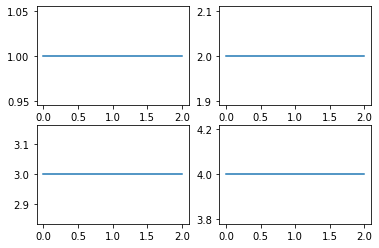

In [9]:
fig = plt.figure()
j = 1
for increment in range(4):
    ax = fig.add_subplot(2, 2, j)
    plt.plot([0, 1, 2], [j, j ,j])
    j += 1

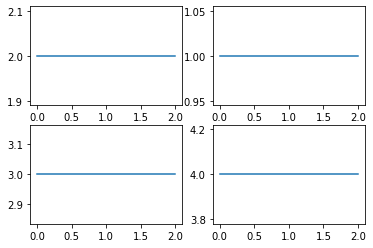

In [10]:
fig = plt.figure()
j = 1
for increment in range(4):
    ax = fig.add_subplot(2, 2, f.reindex(j))
    plt.plot([0, 1, 2], [j, j ,j])
    j += 1

In [11]:
2 // 2

1